In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
file_path = '/restricted/projectnb/ma679/ProcessedData/yc4a/data_new.csv'
df_clean = pd.read_csv(file_path)

# data cleaning

In [2]:
rename_dict = {
    '3E0R3NZ': 'X3E0R3NZ',
    '3E0234Z': 'X3E0234Z',
    '3E033VJ': 'X3E033VJ',
    '3E0P7VZ': 'X3E0P7VZ',
    '3E0T3BZ': 'X3E0T3BZ'
}
df_clean.rename(columns=rename_dict, inplace=True)

# Select the specified columns
selected_columns = [
    'AGE', 'AWEEKEND', 'ELECTIVE', 'FEMALE', 'LOS', 'I10_DELIVERY',
    'I10_INJURY', 'I10_MULTINJURY', 'I10_SERVICELINE', 'I10_NDX',
    'I10_NPR', 'PAY1', 'PL_NCHS', 'RESIDENT', 'TOTCHG',
    'ZIPINC_QRTL', 'X3E0R3NZ', 'X3E0234Z', 'X3E033VJ',
    'X3E0P7VZ', 'X3E0T3BZ', 'Z7982', 'Z79899', 'Z794',
    'Z7984', 'Z7901', 'Z7902', 'Z7951', 'Z79891', 'Z791', 'Z7952', 'return30'
]
df_clean_selected = df_clean[selected_columns]

# Display the first few rows and columns of the cleaned dataset
df_clean_selected.head(), df_clean_selected.columns

(   AGE  AWEEKEND  ELECTIVE  FEMALE  LOS  I10_DELIVERY  I10_INJURY  \
 0   24         0         1       1    4             1           0   
 1   17         0         1       1    2             1           0   
 2   32         0         1       1    5             1           0   
 3   30         0         0       1    3             1           0   
 4   25         0         0       1    5             1           0   
 
    I10_MULTINJURY  I10_SERVICELINE  I10_NDX  ...  Z79899  Z794  Z7984  Z7901  \
 0               0                1        8  ...       0     0      0      0   
 1               0                1        7  ...       0     0      0      0   
 2               0                1       10  ...       0     0      0      0   
 3               0                1        5  ...       0     0      0      0   
 4               0                1        7  ...       0     0      0      0   
 
    Z7902  Z7951  Z79891  Z791  Z7952  return30  
 0      0      0       0     0      0   

In [3]:
categorical_columns = ['PAY1', 'PL_NCHS', 'I10_INJURY', 'I10_SERVICELINE']
df_clean_selected.loc[:, categorical_columns] = df_clean_selected.loc[:, categorical_columns].astype('category')

# Handle class imbalance using oversampling

df_minority = df_clean_selected[df_clean_selected['return30'] == 1]
df_majority = df_clean_selected[df_clean_selected['return30'] == 0]
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

# Prepare data for training
X = df_oversampled.drop(columns='return30')
y = df_oversampled['return30']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# boosting gradient model

In [4]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, n_estimators=50)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## model checking(xgboost)

In [5]:
# Evaluate the XGBoost model
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"XGBoost Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

XGBoost Accuracy: 0.6432735568213019
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60   1270124
           1       0.62      0.76      0.68   1268387

    accuracy                           0.64   2538511
   macro avg       0.65      0.64      0.64   2538511
weighted avg       0.65      0.64      0.64   2538511



## model update

In [6]:
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.metrics import accuracy_score
# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the XGBoost model with engineered features
xgb_model_poly = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, n_estimators=50)
xgb_model_poly.fit(X_train_poly, y_train)

# Evaluate the model
y_pred_poly = xgb_model_poly.predict(X_test_poly)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
accuracy_poly

0.6438845449162914

## plot

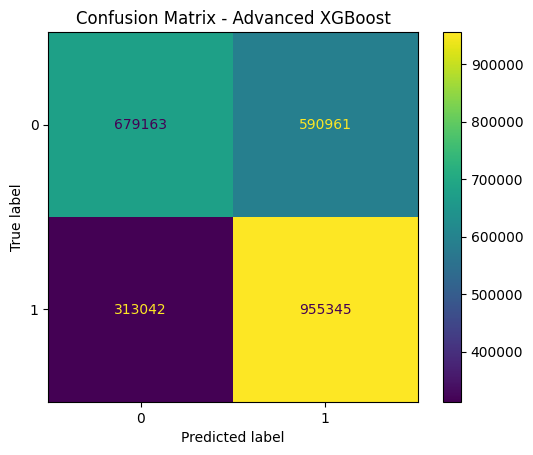

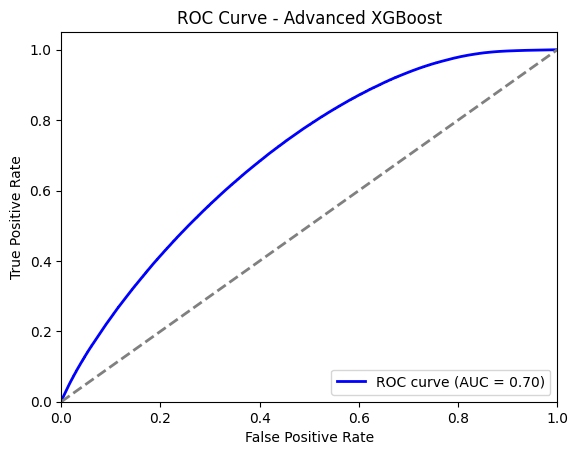

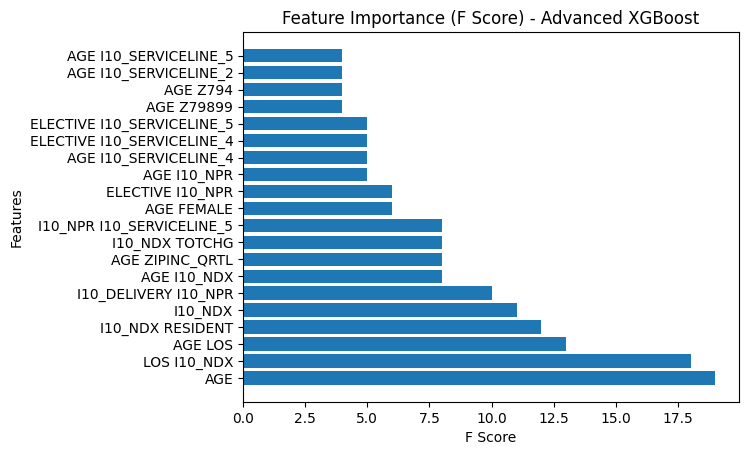

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb_model_poly, X_test_poly, y_test)
plt.title("Confusion Matrix - Advanced XGBoost")
plt.show()

# ROC Curve
y_pred_proba = xgb_model_poly.predict_proba(X_test_poly)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Advanced XGBoost')
plt.legend(loc="lower right")
plt.show()

feature_names = poly.get_feature_names_out(X.columns)

import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming `poly` is the PolynomialFeatures object used for feature transformation
# Get feature names after polynomial transformation
feature_names = poly.get_feature_names_out(X.columns)

# Retrieve feature importance from the model
booster = xgb_model_poly.get_booster()
feature_importance = booster.get_score(importance_type='weight')

# Map feature indices to their actual names
mapped_features = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Sort features by importance
sorted_features = sorted(mapped_features.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
features = [k for k, _ in sorted_features[:20]]  # Get the top 20 features
scores = [v for _, v in sorted_features[:20]]

# Plot feature importance
plt.barh(features, scores)
plt.xlabel('F Score')
plt.ylabel('Features')
plt.title('Feature Importance (F Score) - Advanced XGBoost')
plt.show()



# neural network model

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [12]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a neural network model using scikit-learn's MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Evaluate the model
test_accuracy_nn = mlp.score(X_test_scaled, y_test)
y_pred_nn = mlp.predict(X_test_scaled)
classification_rep_nn = classification_report(y_test, y_pred_nn)

print(f'Accuracy: {test_accuracy_nn}')
print(classification_rep_nn)


Accuracy: 0.6489477492908244
              precision    recall  f1-score   support

           0       0.68      0.56      0.62   1270124
           1       0.63      0.73      0.68   1268387

    accuracy                           0.65   2538511
   macro avg       0.65      0.65      0.65   2538511
weighted avg       0.65      0.65      0.65   2538511



## Model checking

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Set up a fixed number of epochs
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, random_state=42)

# Train the model and store the accuracy
mlp.fit(X_train_scaled, y_train)
train_accuracy = mlp.score(X_train_scaled, y_train)
test_accuracy = mlp.score(X_test_scaled, y_test)

y_pred_nn = mlp.predict(X_test_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Neural Network")
plt.show()

# logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
model = SelectFromModel(log_reg, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

# Train a logistic regression model using selected features
log_reg_selected = LogisticRegression(random_state=42, max_iter=1000)
log_reg_selected.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = log_reg_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(classification_rep)
